# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [35]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm



import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
from FCGPFA import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from FCGPFA import conv, conv_subspace
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset
from model_trainer import Trainer

# Load data from local file

In [59]:
data_path = "/home/qix/user_data/allen_spike_trains/798911424drifting_gratings.pkl"
npadding = 100

with open(data_path, 'rb') as f:
    experiment = pickle.load(f)
    spikes = experiment['spikes']


spikes is a list with six element. Each element is a 3d numpy arrary and represents the spike trains of one brain area. 
The dimension of the array is 
```
(the number of trials, the number of neurons, the number of time points in a trial) 
```
Each time point is an integer indicating how many spikes are emitted in that 1ms time bin. It's mostly zeros. 
Each trial is already aligned, where 349 time points represent -100ms to 250ms relative to the stimulus onset. (That's why we set npadding to 100, meaning we have 100 time points before the stimulus onset and 150 time points after the stimulus onset.)

In [60]:
len(spikes), spikes[0].shape

(6, (630, 78, 349))

# Train a model

In [106]:
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'
torch.manual_seed(1)
np.random.seed(1)

params = {
    'batch_size': 64,
    'beta': 0.1,
    'decoder_architecture': 1,
    'd_model': 128,
    'dim_feedforward': 512,
    'dropout': 0.0,
    'weight_decay': 0.0,
    'lr_transformer': 0.0001,
    'lr_sti': 0.01,
    'lr_cp': 0.01,
    'epoch_warm_up': 10,
    'epoch_fix_latent': 0,
    'epoch_patience': 5,
    'epoch_max': 100,
    'nfactor': 4,
    'nhead': 2,
    'nl_dim': 16,
    'num_B_spline_basis': 20,
    'num_layers': 2,
    'num_merge': 10,
    'sample_latent': False,
    'K_tau': 100,
    'K_sigma2': 1.0,
    'nsubspace': 1,
    'nlatent': 1,
    'coupling_basis_num': 3,
    'coupling_basis_peaks_max': 20,
    'use_self_coupling': True,
    'penalty_overlapping': None,
    }

trainer = Trainer(spikes, ckp_path, params, npadding=npadding)
trainer.train(verbose=True, only_stimulus=False, fix_stmulus=False, fix_latents=True)

Start training model with parameters: {'batch_size': 64, 'beta': 0.1, 'decoder_architecture': 1, 'd_model': 128, 'dim_feedforward': 512, 'dropout': 0.0, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01, 'epoch_warm_up': 10, 'epoch_fix_latent': 0, 'epoch_patience': 5, 'epoch_max': 100, 'nfactor': 4, 'nhead': 2, 'nl_dim': 16, 'num_B_spline_basis': 20, 'num_layers': 2, 'num_merge': 10, 'sample_latent': False, 'K_tau': 100, 'K_sigma2': 1.0, 'nsubspace': 1, 'nlatent': 1, 'coupling_basis_num': 5, 'coupling_basis_peaks_max': 20, 'use_self_coupling': False, 'penalty_overlapping': None}
Data processed. Train set size: 504, Test set size: 126
Model initialized. Training on cuda
Epoch 1/100, Train Loss: 0.0406, Test Loss: 0.0330
Epoch 2/100, Train Loss: 0.0325, Test Loss: 0.0317
Epoch 3/100, Train Loss: 0.0317, Test Loss: 0.0312
Epoch 4/100, Train Loss: 0.0312, Test Loss: 0.0307
Epoch 5/100, Train Loss: 0.0307, Test Loss: 0.0302
Epoch 6/100, Train Loss: 0.0302, Test Lo

0.02665260061621666

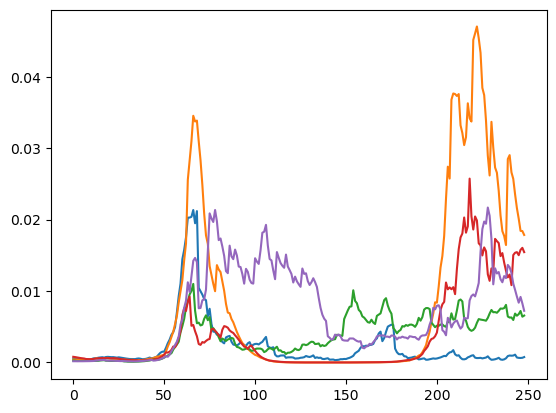

In [107]:
firing_rate_test, sti_mu_test, sti_logvar_test = trainer.predict(return_torch=True, dataset='test', 
                                       only_stimulus=False, fix_stmulus=False, fix_latents=True)
plt.plot(np.exp(firing_rate_test[100:105, 150, :].numpy().T))


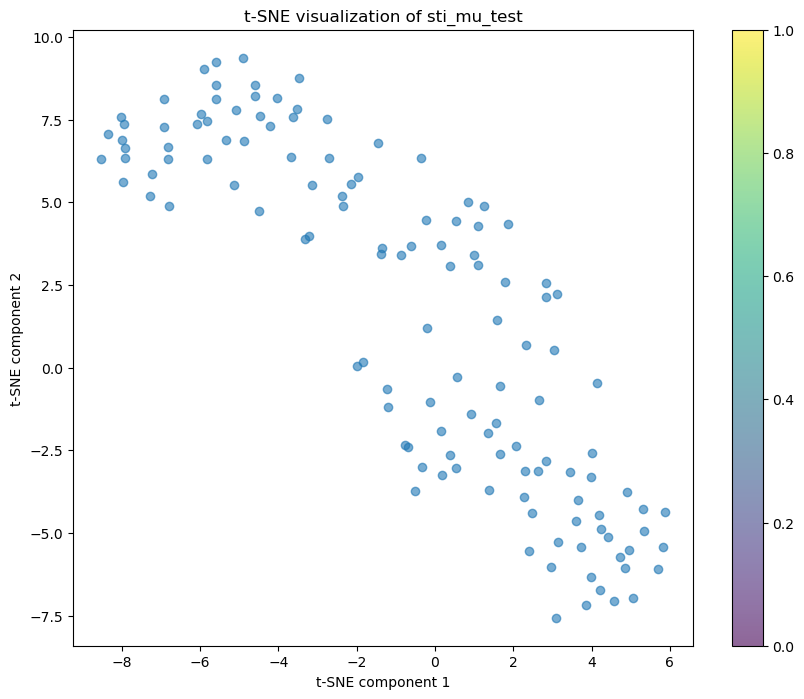

In [108]:
# Convert sti_mu_test to numpy array if it's a torch tensor
sti_mu_test_np = sti_mu_test.detach().cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(sti_mu_test_tsne[:, 0], sti_mu_test_tsne[:, 1], alpha=0.6)
plt.title('t-SNE visualization of sti_mu_test')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar()
plt.show()

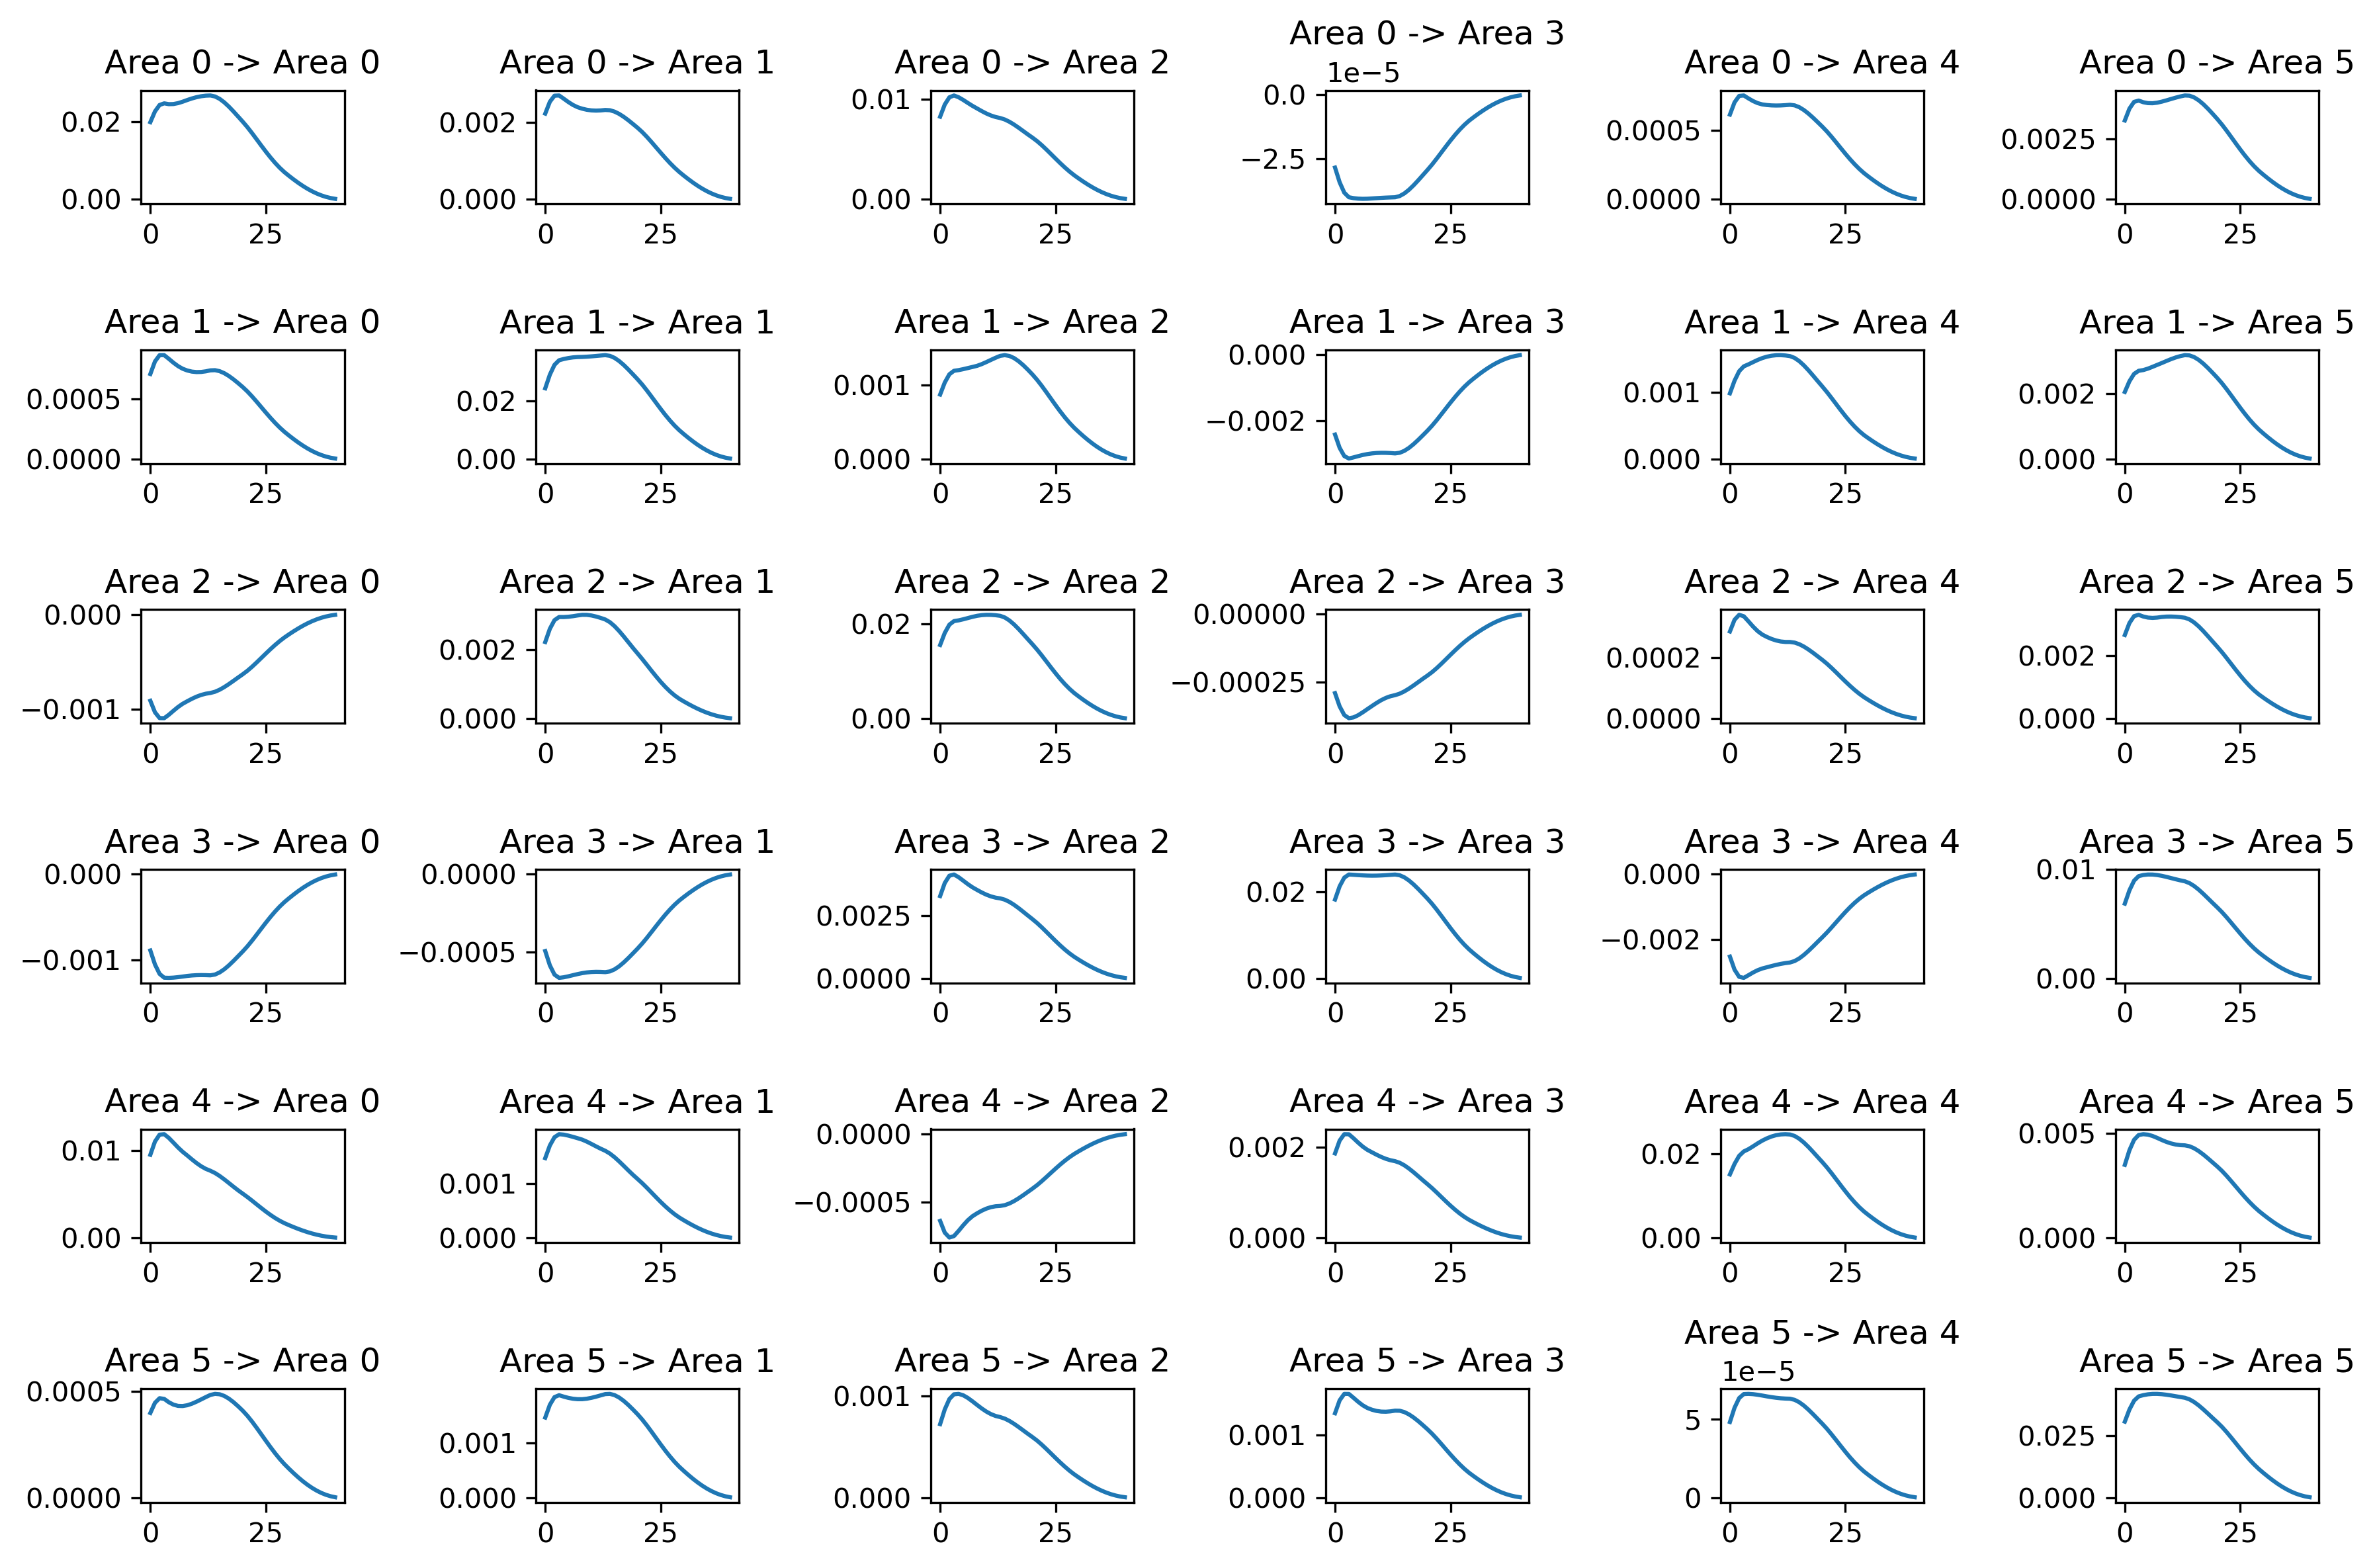

In [109]:
# Create a figure with N x N subplots for each area pair
narea = len(trainer.model.coupling_filters)
fig, axes = plt.subplots(narea, narea, figsize=(12, 8), dpi=300)

# Plot coupling filters for each area pair
for i in range(narea):
    for j in range(narea):
        filters = (
            trainer.model.coupling_filters[i][j].detach().cpu().numpy()
            * trainer.model.cp_weight_sending[i][j].mean().detach().cpu().numpy()
            * trainer.model.cp_weight_receiving[i][j].mean().detach().cpu().numpy() 
        )
        axes[i,j].plot(filters[:,0])
        axes[i,j].set_title(f'Area {i} -> Area {j}')

plt.tight_layout()
plt.show()
